In [1]:
import sys
sys.path.append("../src")
from data_processing import DataLoader
from train import ModelTrainer

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [3]:
data_loader = DataLoader()
df = data_loader.load_data("../data/processed/feature_engineered_data_with_target.csv")

In [4]:
# Inspect dataset
display(df.head())

# Check target distribution
print("\nTarget distribution:")
display(df['is_high_risk'].value_counts())

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,FraudResult,transaction_hour,transaction_day,transaction_month,transaction_year,total_transaction_amount,avg_transaction_amount,transaction_count,std_transaction_amount,is_high_risk
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,...,0,2,15,11,2018,109921.75,923.712185,119,3042.294251,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,...,0,2,15,11,2018,109921.75,923.712185,119,3042.294251,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,...,0,2,15,11,2018,1000.00,500.000000,2,0.000000,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,...,0,3,15,11,2018,228727.20,6019.136842,38,17169.241610,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,...,0,3,15,11,2018,228727.20,6019.136842,38,17169.241610,0



Target distribution:


is_high_risk
0    91571
1     4091
Name: count, dtype: int64

### Prepare Features and Target
Separate features (`X`) and target (`y`).  

In [5]:
# Target
y = df["is_high_risk"]

# Features (drop CustomerId and target)
X = df.drop(columns=["CustomerId", "is_high_risk"]).select_dtypes(include=["int64", "float64"])
X.head()


,CountryCode,Amount,Value,PricingStrategy,FraudResult,transaction_hour,transaction_day,transaction_month,transaction_year,total_transaction_amount,avg_transaction_amount,transaction_count,std_transaction_amount
0,256,1000.0,1000,2,0,2,15,11,2018,109921.75,923.712185,119,3042.294251
1,256,-20.0,20,2,0,2,15,11,2018,109921.75,923.712185,119,3042.294251
2,256,500.0,500,2,0,2,15,11,2018,1000.00,500.000000,2,0.000000
3,256,20000.0,21800,2,0,3,15,11,2018,228727.20,6019.136842,38,17169.241610
4,256,-644.0,644,2,0,3,15,11,2018,228727.20,6019.136842,38,17169.241610


### Split Data into Training and Test Sets
We set a `random_state` to ensure reproducibility and stratify to preserve class distribution.

In [6]:
# %%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Initialize Model Trainer

In [7]:
trainer = ModelTrainer(X_train, y_train)

### Train and Log Models with MLflow
We perform optional hyperparameter tuning with GridSearchCV and log all models, metrics, and artifacts to MLflow.

In [8]:
trainer.train_and_log_models(
    models=["logistic_regression", "random_forest", "xgboost"],
    tune=True,
    random_state=42
)

2025/12/16 23:20:50 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/16 23:20:50 INFO mlflow.store.db.utils: Updating database tables
2025/12/16 23:20:50 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/16 23:20:50 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/16 23:20:50 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/16 23:20:50 INFO alembic.runtime.migration: Will assume non-transactional DDL.


### Evaluate the Best Model on Test Set
Assess model performance on unseen data using Accuracy, Precision, Recall, F1 Score, and ROC-AUC.

In [9]:
best_model, test_metrics = trainer.evaluate_best_model(X_test, y_test)

print("Best Model:", type(best_model).__name__)
print("Test Metrics:")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")


Best Model: LogisticRegression
Test Metrics:
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000
roc_auc: 1.0000


### Visualize ROC Curve
This helps understand the model's discrimination capability.

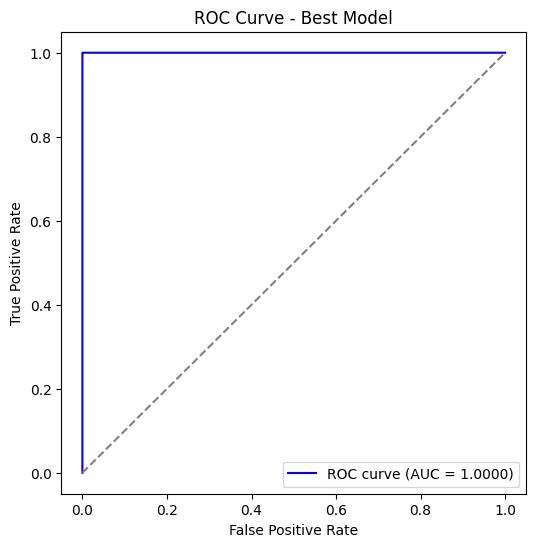

In [10]:
# Your ROC code
y_pred_proba = best_model.predict_proba(trainer.scaler.transform(X_test))[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0,1],[0,1], color="grey", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best Model")
plt.legend(loc="lower right")
plt.show()
